In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers

import IPython.display as ipd

In [2]:
data_path = 'C:\ML\DataBases\mini_speech_commands'

In [3]:
def res_plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        metric_mean = np.mean(metric[1][-3:])
        val_metric_mean = np.mean(val_metric[1][-3:])

        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.ylim(0, metric_mean + val_metric_mean)
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

## Загрузка датасета

In [4]:
training_set, validation_set = keras.utils.audio_dataset_from_directory(
    directory=data_path,
    batch_size=16,
    validation_split=0.2,
    output_sequence_length=16_000,
    subset='both',
    seed=42
)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [5]:
label_names = training_set.class_names
label_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

## Обработка данных

In [6]:
def decode_audio(audio_binary):
    """переввод звука в массив данных"""
    audio, sampling_rate = tf.audio.decode_wav(contents=audio_binary)
    return audio, sampling_rate

In [7]:
def squeeze(audio, labels):
    '''перевод звука в формат mono'''
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

In [8]:
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [9]:
audio, labels = next(iter(training_set))  # берем следующий элемент из генератора (один тензор размером batch_size)
# чтобы исключить ощибку, сначала мы итерируем генератор

In [10]:
labels

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([2, 4, 2, 1, 5, 4, 0, 6, 4, 3, 6, 4, 4, 0, 5, 3])>

In [11]:
audio

<tf.Tensor: shape=(16, 16000), dtype=float32, numpy=
array([[-1.2207031e-04, -3.0517578e-05, -1.2207031e-04, ...,
        -1.5258789e-04, -1.5258789e-04, -9.1552734e-05],
       [-8.8500977e-04,  2.1850586e-02,  1.6906738e-02, ...,
         2.5726318e-02,  3.5675049e-02,  1.5930176e-02],
       [-4.8828125e-04, -7.0190430e-04, -6.1035156e-04, ...,
        -8.3618164e-03, -7.8125000e-03, -7.2631836e-03],
       ...,
       [-2.1972656e-03, -2.5329590e-03, -2.4414062e-03, ...,
        -4.6691895e-03, -3.4484863e-03, -3.0822754e-03],
       [-2.0919800e-01, -2.0974731e-01, -2.0965576e-01, ...,
        -2.1124268e-01, -2.1057129e-01, -2.1231079e-01],
       [ 4.5776367e-04,  9.1552734e-04,  8.8500977e-04, ...,
        -7.9345703e-04, -6.4086914e-04, -1.2512207e-03]], dtype=float32)>

In [12]:
ipd.display(ipd.Audio(audio[0], rate=16_000))

In [13]:
def plot_wave(waveform, label): 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.plot(waveform) 
    plt.xlim([0, 16000]) 
    plt.ylim([-1, 1]) 
    plt.xlabel('Time') 
    plt.ylabel('Amplitude') 
    plt.grid(True) 
    plt.show()

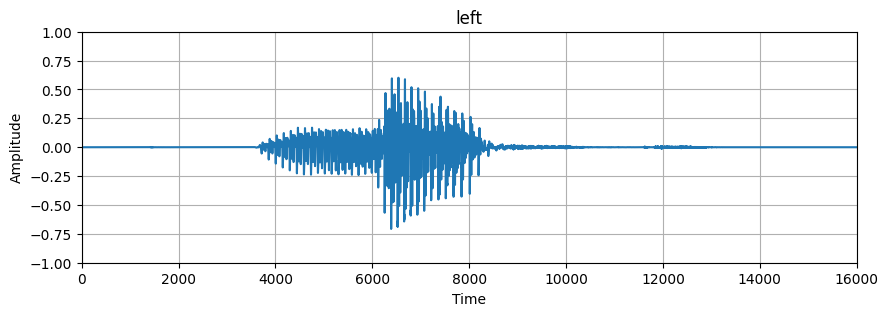

In [14]:
plot_wave(audio[0], label_names[labels[0]])

In [15]:
def get_spectrogram(waveform): 
    '''Преобразование данных в спектрограмму'''
    # кратковременное преобразование Фурье STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

In [16]:
def plot_spectrogram(spectrogram, label): 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.imshow(log_spec, aspect='auto', origin='lower') 
    plt.colorbar(format='%+2.0f dB') 
    plt.xlabel('Time') 
    plt.ylabel('Frequency') 
    plt.show()

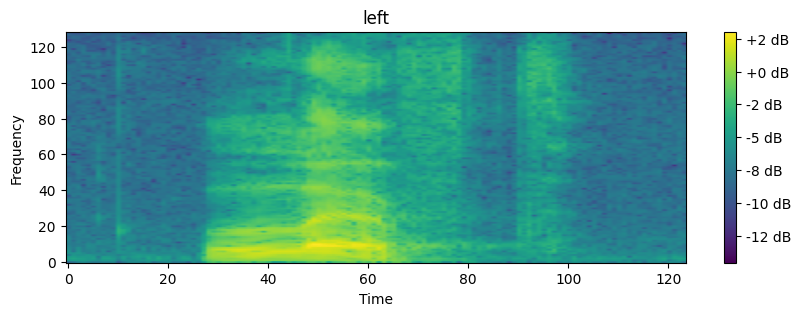

In [17]:
plot_spectrogram(get_spectrogram(audio[0]), label_names[labels[0]])

`помотреть на все дорожки`

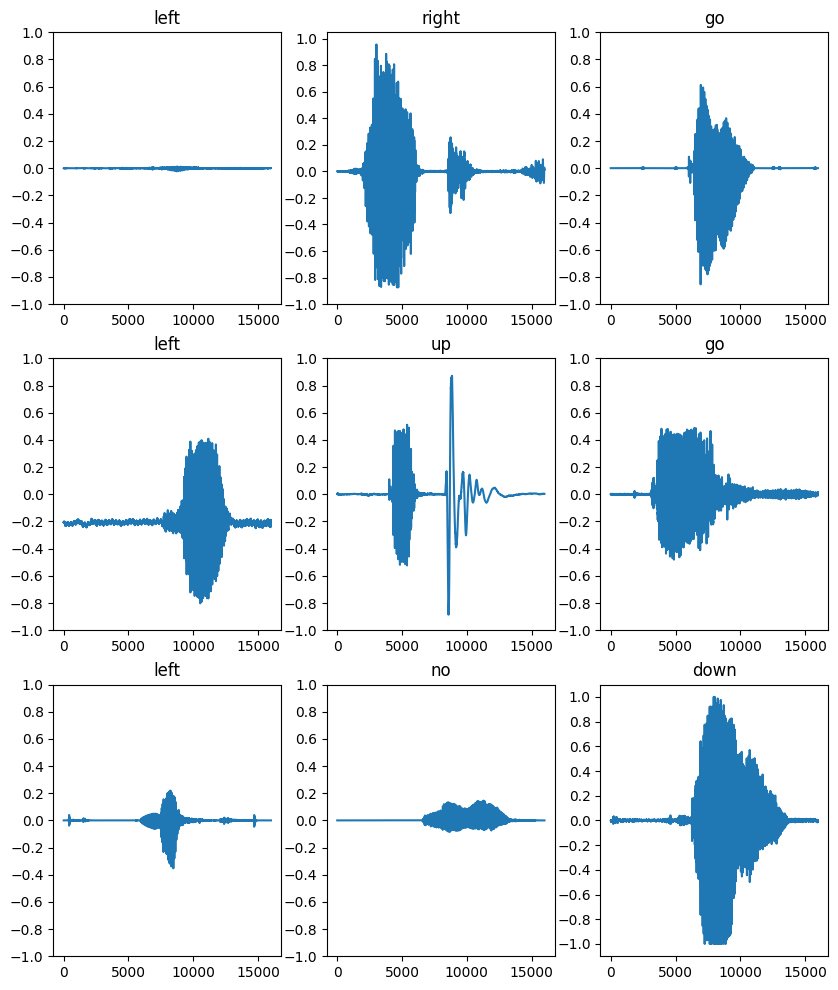

In [18]:
rows, cols = 3, 3

audio, label = next(iter(training_set))

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(zip(audio, label)):
  if i == rows * cols: break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio)
  ax.set_yticks(np.linspace(-1, 1, 10+1))
  label = label_names[label]
  ax.set_title(label)

plt.show()

In [19]:
audio, label = next(iter(training_set))

`вывод спектрограммы для всех звуков`

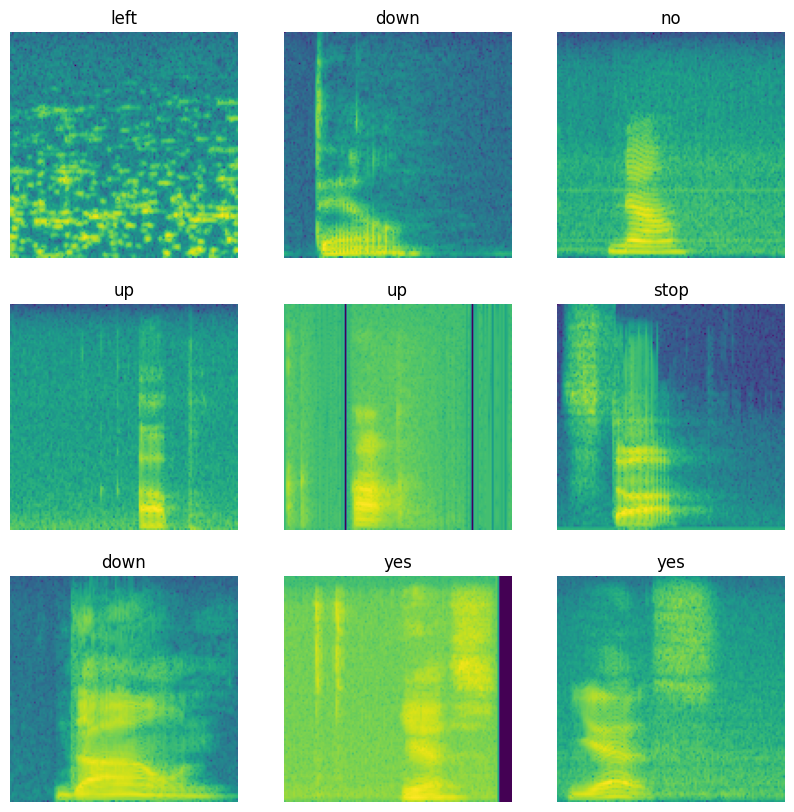

In [20]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (audio, label) in enumerate(zip(audio, label)):
    if i == rows * cols: break
    spectrogram = get_spectrogram(audio) 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    r = i // cols
    c = i % cols  
    ax = axes[r][c]
    ax.imshow(log_spec, aspect='auto', origin='lower') 
    label = label_names[label]
    ax.set_title(label)
    ax.axis('off')

plt.show()

## Преобразование аудио в изображение спектрограммы

In [21]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

## Разделение данных

In [22]:
train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 
  
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

`проверка размерности`

In [23]:
# все размеры должны совпадать

train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 
  
print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


## Построение модели

In [24]:
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names)

Input shape: (124, 129, 1)


In [25]:
model = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=input_shape), 

        tf.keras.layers.Resizing(64, 64), 
        tf.keras.layers.Normalization(), 
          
        tf.keras.layers.Conv2D(64, 3, activation='relu'), 
        tf.keras.layers.Conv2D(128, 3, activation='relu'), 
        tf.keras.layers.MaxPooling2D(), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Flatten(), 
          
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.5), 
          
        tf.keras.layers.Dense(num_labels, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0

In [27]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'] 
)

In [28]:
epochs = 10
verbose = True

monitor = 'loss'
min_delta = 0.01
patience = 3

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose)]

In [29]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10




400/400 [==============================] - 113s 281ms/step - loss: 1.4070 - accuracy: 0.5189 - val_loss: 0.8647 - val_accuracy: 0.7475
Epoch 2/10
400/400 [==============================] - 110s 274ms/step - loss: 0.7674 - accuracy: 0.7497 - val_loss: 0.6462 - val_accuracy: 0.8188
Epoch 3/10
400/400 [==============================] - 110s 275ms/step - loss: 0.5406 - accuracy: 0.8191 - val_loss: 0.5478 - val_accuracy: 0.8400
Epoch 4/10
400/400 [==============================] - 110s 274ms/step - loss: 0.4226 - accuracy: 0.8561 - val_loss: 0.4696 - val_accuracy: 0.8500
Epoch 5/10
400/400 [==============================] - 110s 274ms/step - loss: 0.3746 - accuracy: 0.8794 - val_loss: 0.4864 - val_accuracy: 0.8438
Epoch 6/10
400/400 [==============================] - 110s 274ms/step - loss: 0.2957 - accuracy: 0.9002 - val_loss: 0.4927 - val_accuracy: 0.8675
Epoch 7/10
400/400 [==============================] - 110s 274ms/step - loss: 0.2410 - accuracy: 0.9183 - val_loss: 0.4859 - val_accu

## Графики обучения модели

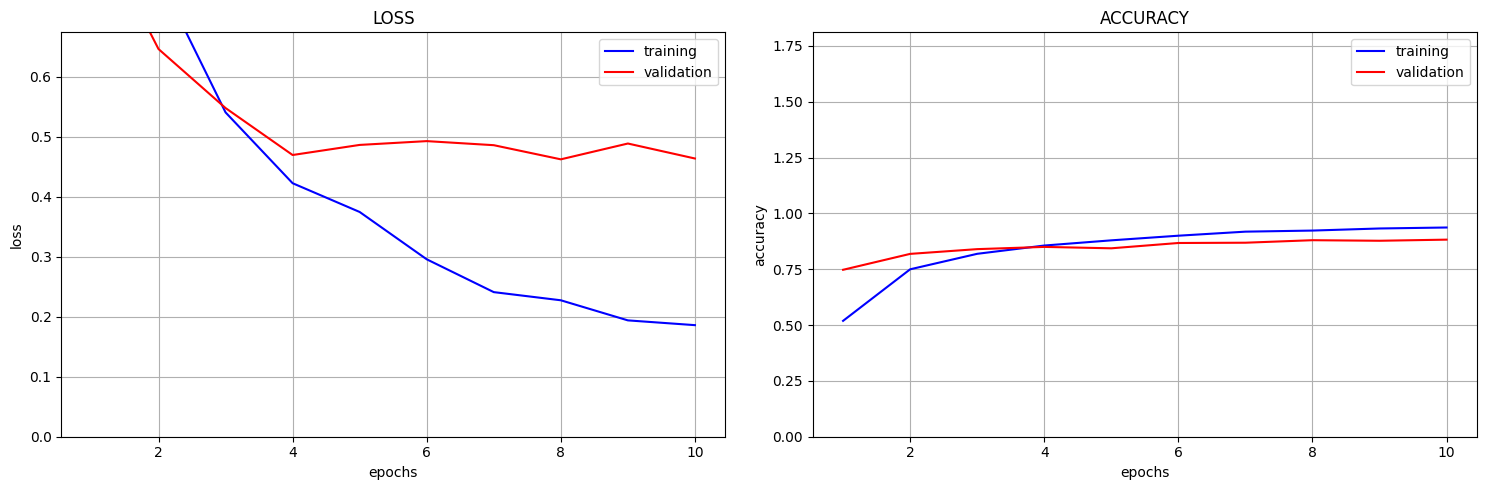

In [30]:
res_plot_model_metrics(history)

## Оценка модели

50/50 [==============================] - 2s 27ms/step


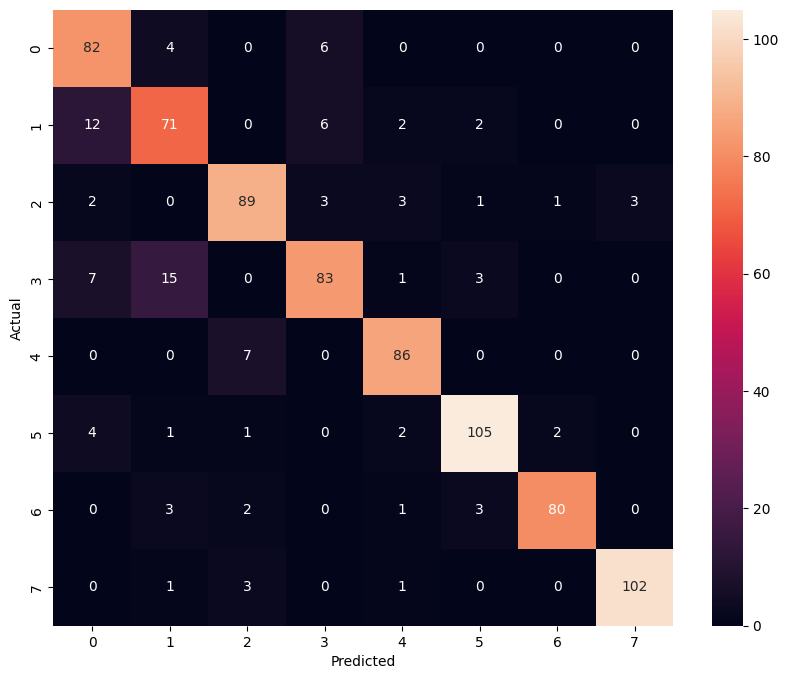

In [31]:
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 
  
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [32]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.89      0.82        92
           1       0.75      0.76      0.76        93
           2       0.87      0.87      0.87       102
           3       0.85      0.76      0.80       109
           4       0.90      0.92      0.91        93
           5       0.92      0.91      0.92       115
           6       0.96      0.90      0.93        89
           7       0.97      0.95      0.96       107

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.88      0.87      0.87       800



## Тестирование

In [35]:
path = fr'0a9f9af7_nohash_1.wav'

In [36]:
Input = tf.io.read_file(str(path)) 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,) 
audio, labels = squeeze(x, 'yes')

In [37]:
waveform = audio 
ipd.display(ipd.Audio(waveform, rate=16_000))

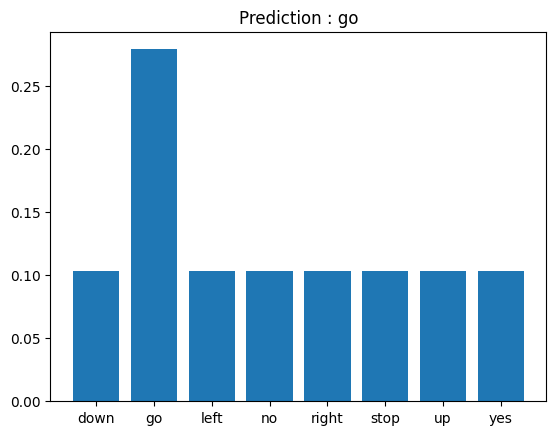

In [38]:
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 
  
prediction = model(x) 
plt.bar(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()